# 캐글 경진대회 따라해보기

## 1. EDA

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/exploration/exploration_06/data/'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


### 1-1.결측치 확인

<AxesSubplot:>

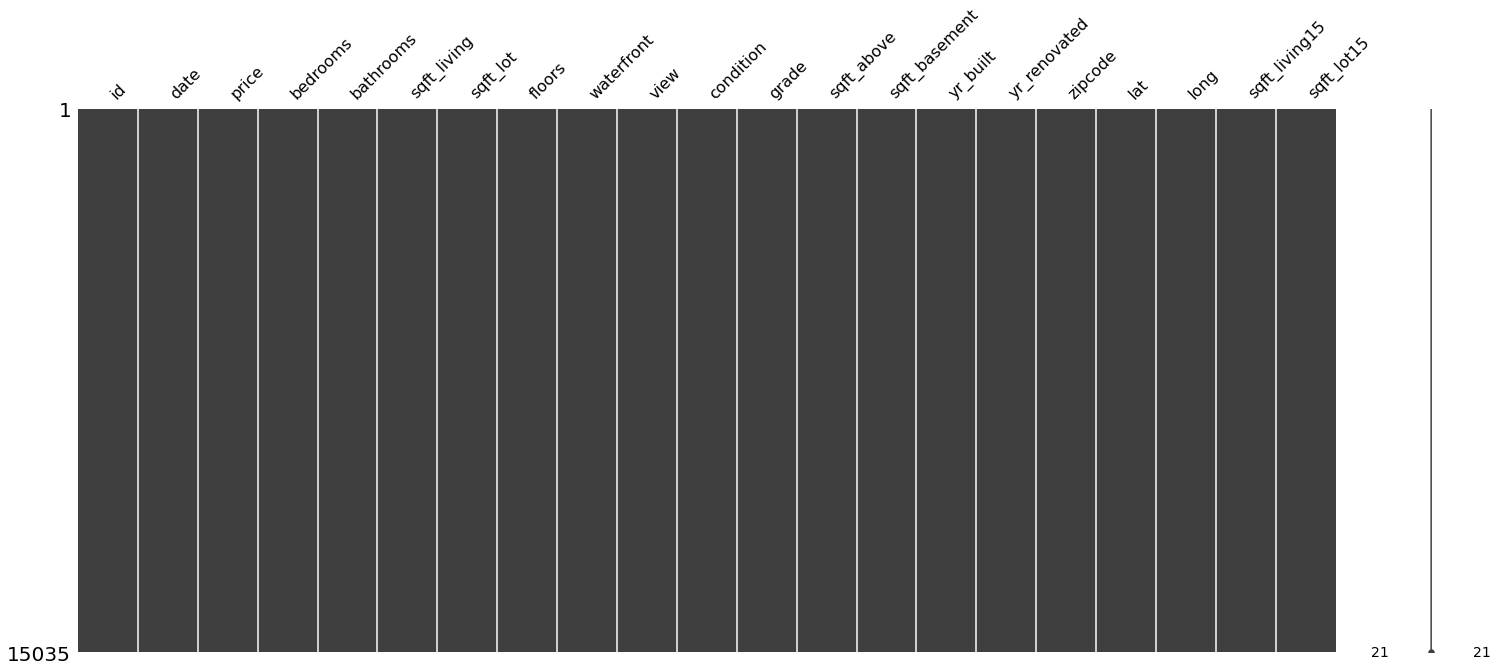

In [3]:
msno.matrix(train)

<AxesSubplot:>

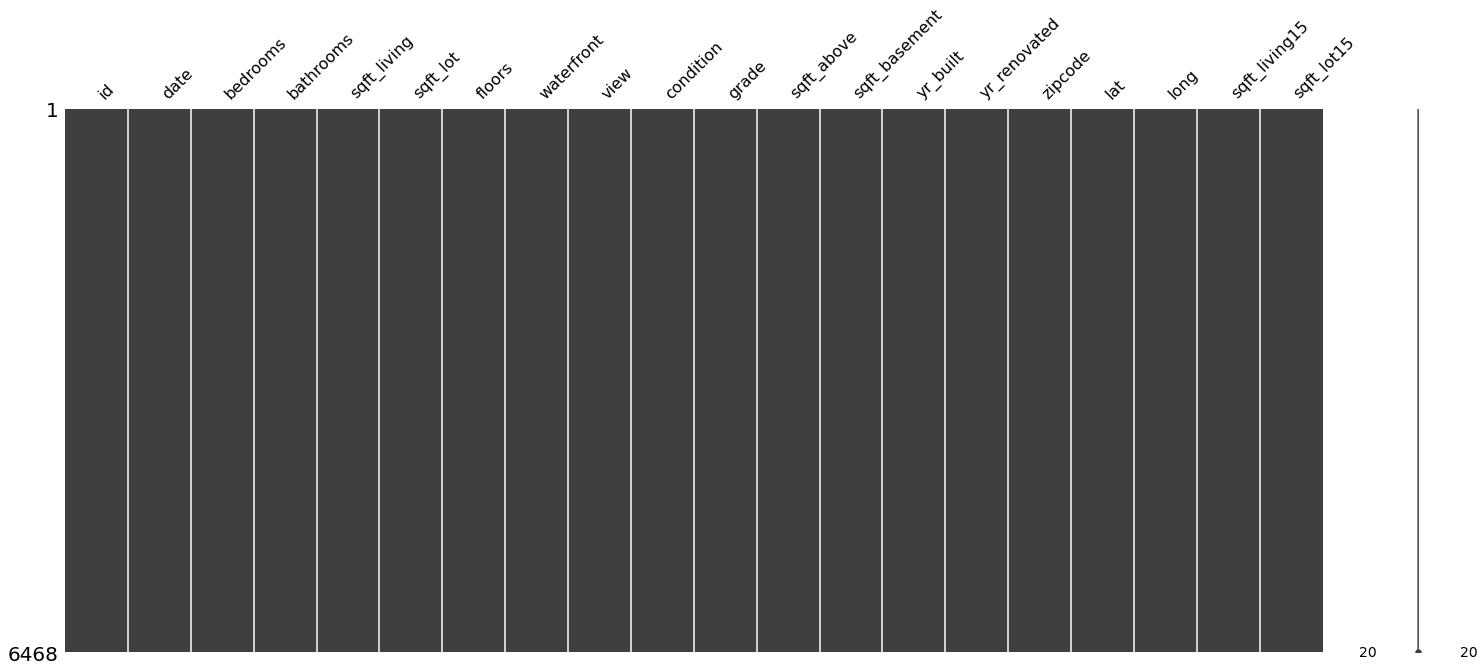

In [4]:
msno.matrix(test)

In [5]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [6]:
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 1-2. 데이터 탐색

**목적변수 살펴보기**

<AxesSubplot:xlabel='price', ylabel='Density'>

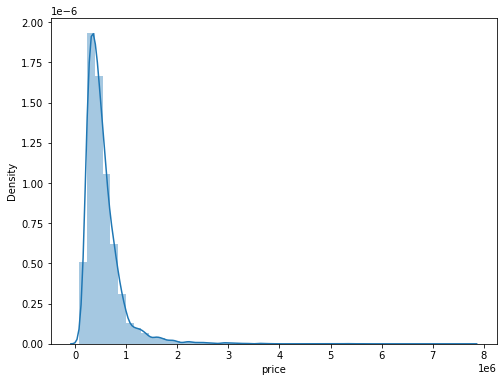

In [7]:
# 목적변수 살펴보기
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

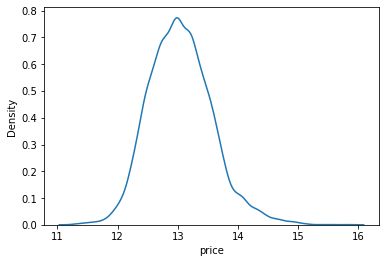

In [8]:
#log 변환을 통한 
train['price'] = np.log1p(train['price'])
#histogram
sns.kdeplot(train['price'])
plt.show()

**스피어만 상관계수**

- 계량형,혹은 순서형 변수 사이의 단순 관계의 강도와 방향을 조사하고자 할 떄 씀. (단순 관계에서 두 변수는 동일한 상대적인 방향으로 이동하는 경향은 있음나 반드시 일정한 비율로 변화하는 것은 아니기 때문에)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

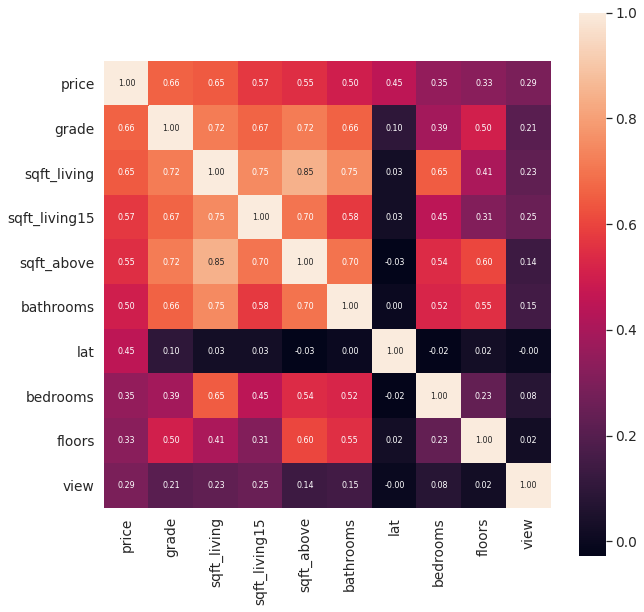

In [9]:
# 가격과 correlation이 높은 상위 10개의 heatmap

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

**이상치 제거**

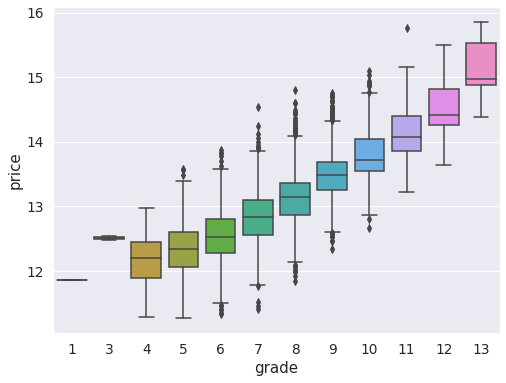

In [12]:
#상관계수가 가장 컸던 price와의 이상치 제거
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

- 집의 등급이 높으면 가격이 좋아진다.

- 하지만 등급 3에서 뜬금없이 가격이 높음. 

- 7-9등급에서 이상치가 많음. 

- 등급 8, 11에서의 이상치가 크다. 

In [13]:
train[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [14]:
train[(train['price']>14.5) & (train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [15]:
train[(train['price']>14.7) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [16]:
train[(train['price']> 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [17]:
#이상치 열 제거
train = train.drop([2302, 4123, 12346, 7173,2775])

**id, date 변수 정리**

id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거.

In [20]:
y = train['price']

train.drop('price', axis=1, inplace=True)
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [21]:
data = pd.concat((train, test), axis=0)
print(len(data))

21498


In [22]:
# 날짜 전처리
data['date'] = data['date'].apply(lambda x: x[:6]).astype(int)

In [23]:
# 제출용 id 저장 후 제거
train_len = len(train)
sub_id = data['id'][train_len:]
data.drop('id', axis=1, inplace=True)

In [24]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


**각 변수들의 분포 확인**

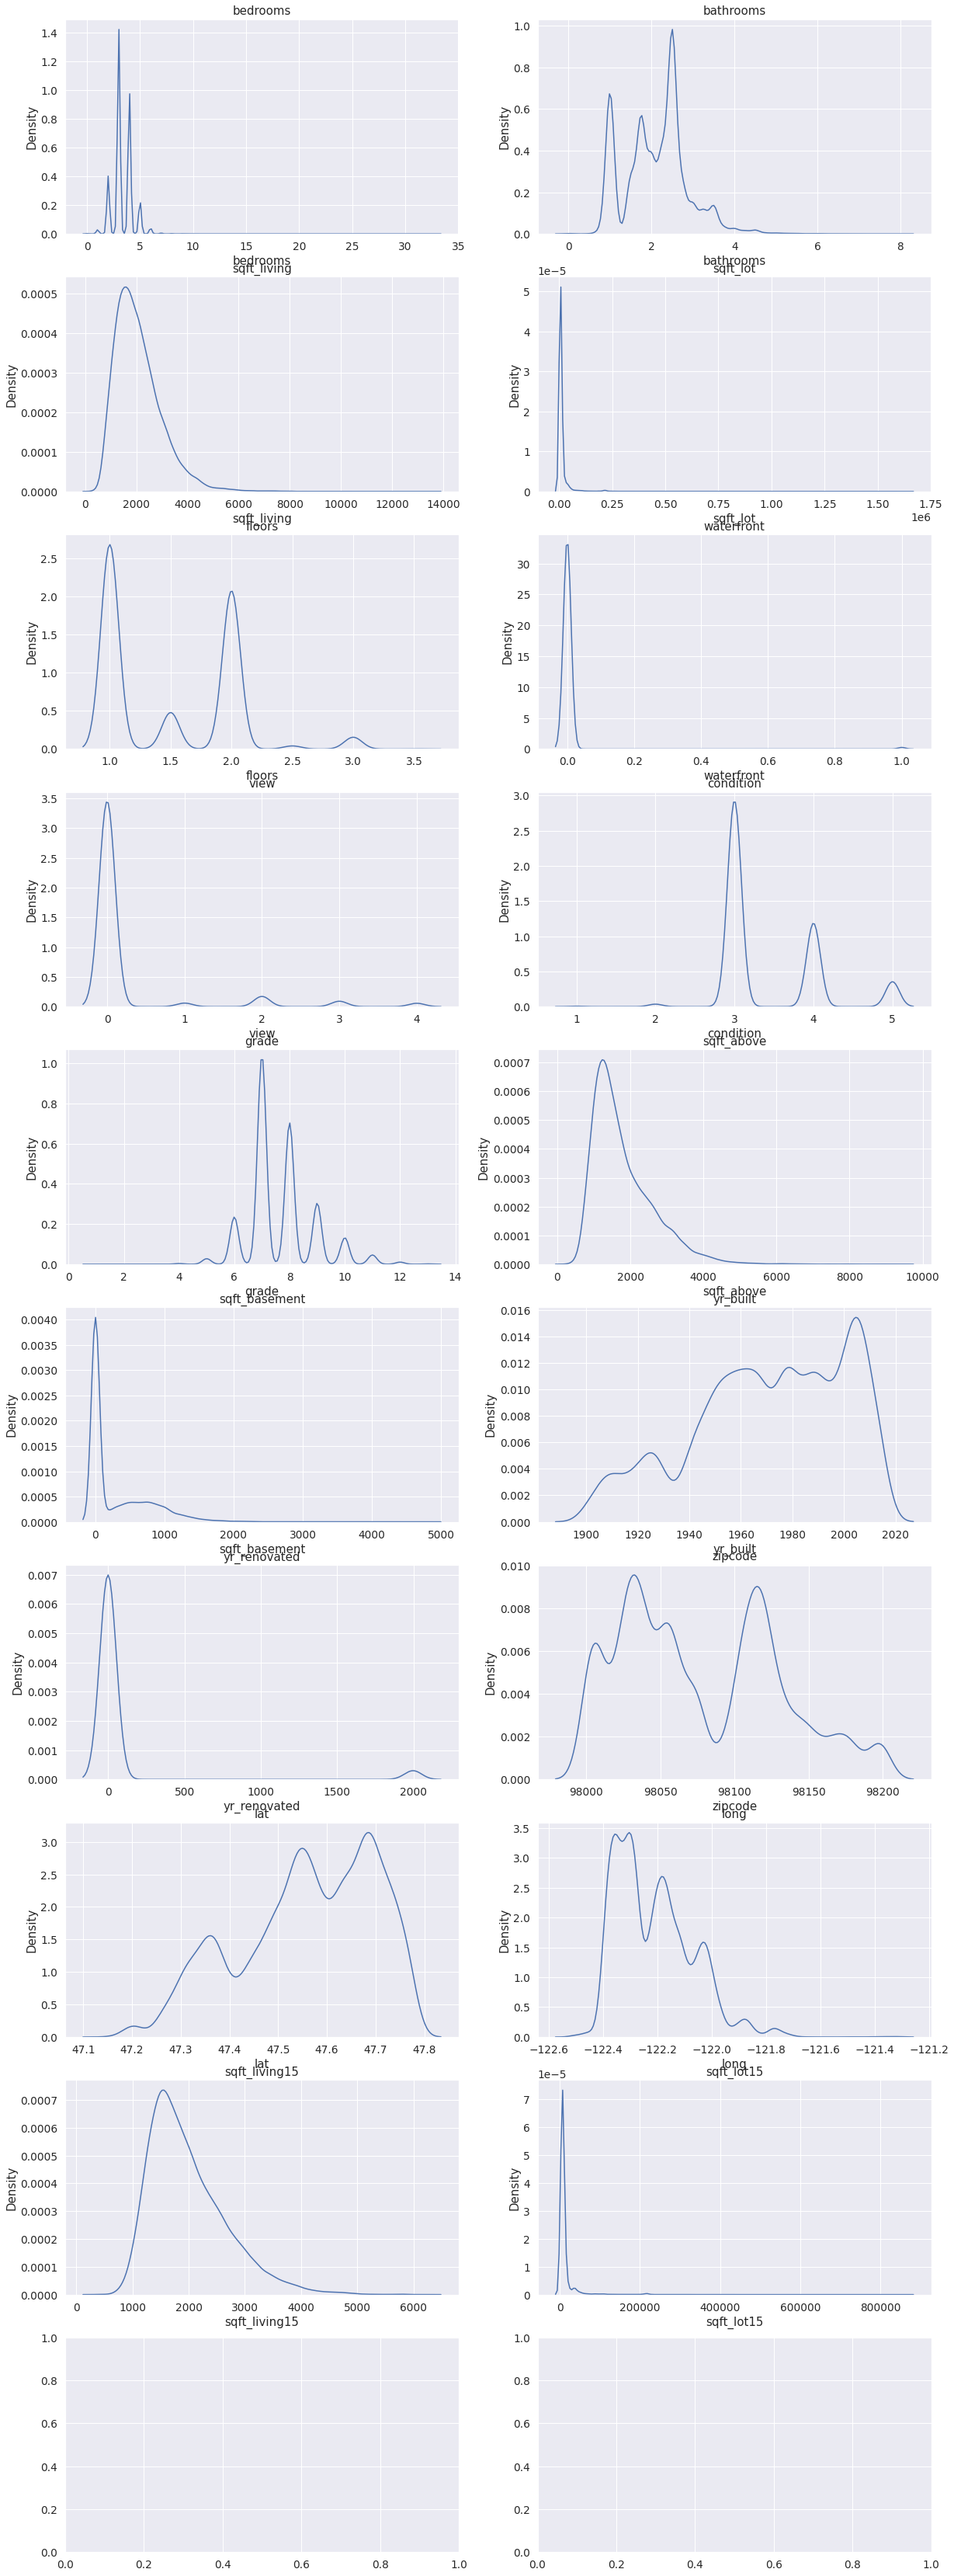

In [30]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break
        

In [31]:
#치우친 값 log변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

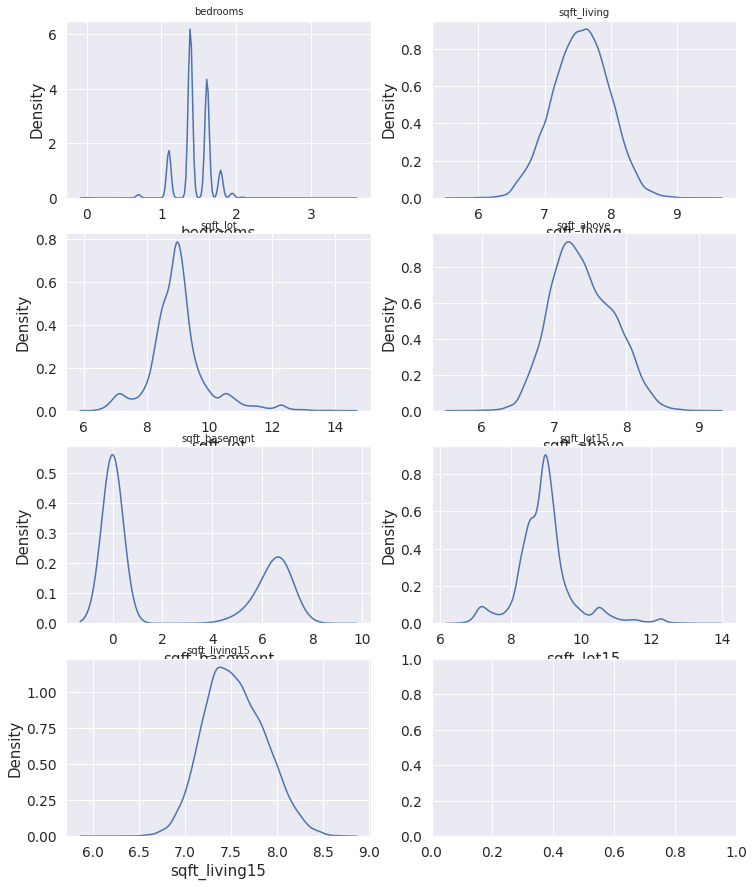

In [32]:
fig, ax = plt.subplots(4, 2, figsize=(12, 15))

count = 0
for row in range(4):
    for col in range(2):
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=10)
        count+=1
        if count == 7 :
            break

### 1-3. feature engineering

In [33]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15030, 19)
(6468, 19)


In [34]:
# 재건축 하지 않은 집들 값 수정
for df in [train, test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [36]:
for df in [train, test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

**우편 번호 기반 평당 가격**

In [42]:
train['price'] = y

In [43]:
train['per_price'] = train['price'] / train['sqft_total_size']

zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train = pd.merge(train, zipcode_price,how='left',on='zipcode')
test = pd.merge(test, zipcode_price,how='left',on='zipcode')

for df in [train, test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean'] 
    del df['var']

In [44]:
del train['per_price']

In [45]:
print(train.shape)
train.head()

(15030, 28)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,price,zipcode_mean,zipcode_var
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,...,8.639588,2.386294,0.818803,7.074117,1.0,0.833509,0,12.309987,9.368147,1.214207
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,...,8.995041,2.098612,0.721756,6.647688,1.0,0.879235,0,12.100718,9.257745,1.023549
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,...,8.923191,3.386294,0.825489,7.427144,1.0,0.840069,0,13.142168,11.307711,0.826257
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,...,8.827615,3.636294,0.843688,7.447751,1.0,0.873824,0,12.458779,10.626177,1.012780
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,...,9.181118,2.886294,0.758837,6.966967,1.0,0.806997,0,12.583999,10.032009,1.002206


In [46]:
print(test.shape)
test.head()

(6468, 27)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zipcode_mean,zipcode_var
0,201412,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,...,7.433075,8.941153,3.636294,0.883465,13.676905,0.574110,0.831333,1,19.255794,2.321564
1,201412,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,...,7.215975,8.517393,4.609438,0.890086,13.772040,0.550478,0.847205,0,18.113257,2.389816
2,201405,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,...,8.468213,11.532051,6.109438,0.745577,15.600098,0.551153,0.734320,0,25.872675,0.772245
3,201504,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,...,7.484930,9.001346,2.386294,0.839232,13.551911,0.552315,0.831535,0,19.759625,2.053191
4,201503,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,...,7.779467,8.932080,3.886294,0.858454,7.544861,1.000000,0.870958,0,11.947244,0.477170


## 2. 모델링과 예측

In [48]:
y = train['price']
del train['price']

In [50]:
print(train.columns)
print(len(train.columns))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'zipcode_mean', 'zipcode_var'],
      dtype='object')
27


In [59]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

**함수 정의**

In [52]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [53]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [54]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

**모델링**

In [60]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
scores = get_scores(models, train, y)
scores.sort_values("RMSE", ascending = True)